# Feature selection ;)

In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis


In [2]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

def evaluate_model(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    surv_fn = model.predict_survival_function(test_X, return_array=False)
    surv_prob = np.row_stack([fn(times) for fn in surv_fn])

    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    ibs = integrated_brier_score(train_y, test_y, surv_prob, times)
    auc, mean_auc = cumulative_dynamic_auc(train_y, test_y, pred, times)

    print(f"Concordance Uno: {round(uno_concordance[0], 3)}")
    print(f"IBS: {round(ibs, 3)}")
    print(f"Mean AUC: {round(mean_auc,3)}")

    return uno_concordance, ibs, mean_auc

In [3]:
# pickle_file = 'data/COX_DATA_FULL_LIVING.pkl'
pickle_file = 'data/COX_DATA_FULL_LIVING_EXPERIMENTAL.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

dataset.drop(['DIAG_KI', 'COD_KI'], axis=1, inplace=True)

In [5]:
dataset.shape

(53082, 58)

In [6]:
yes_categorical=["PRE_TX_TXFUS", 
                "GENDER",
                "ON_DIALYSIS", 
                "ABO_MAT", 
                "ETHCAT", 
                "ETHCAT_DON",
                'HBV_CORE', 
                'DIAB',
                'HCV_SEROSTATUS',  
                'LIV_DON_TY',
                
                # 'HBV_SUR_ANTIGEN', # negative importance
                # "ABO", # negative importance
                # "ABO_DON", # negative importance
                # 'HBV_SUR_ANTIGEN_DON',  # negative importance
                # "GENDER_DON", # negative importance
                # "DIABETES_DON", # zero importance
                
            ]
yes_numerical = [   
                "KI_CREAT_PREOP",
                "SERUM_CREAT",
                "NPKID", 
                "AGE", 
                "HGT_CM_CALC", 
                "BMI_DON_CALC",
                "AGE_DON",
                "DIALYSIS_TIME",
                # "KDPI",

                # HLA with some importance
                # 'DR1', 
                # 'BW6', 
                # 'BW4', 
                # 'RA1',
                # 'A2', 
                # 'DR53', 
                # 'C1', 
                # 'C2', 
                # 'A1',
                # 'RA2', 
                # 'DR51',
                # 'DR52', 
                # 'DQ2', 
                # 'RDR1',
                
                # 'BMIS', # negative importance
                # 'AMIS', # negative importance    
                # "WGT_KG_CALC", # negative importance
                # 'DR52_2', # zero importance
                # 'DR53_2', # zero importance
                # 'B2', # negative importance
                # "CREAT_TRR", # negative importance
                # 'DR2', # negative importance
                # 'RB1',# negative importance
                # 'B1', # negative importance
                # "BMI_CALC", # negative importance 
                # "WGT_KG_DON_CALC", # negative importance
                # "HGT_CM_DON_CALC", # negative importance
                # 'DQ1',# negative importance
                # 'RB2',# negative importance
                # 'RDR2',# negative importance
                ]

In [7]:
dataset[yes_numerical].quantile([0.01, 0.99])

,DIALYSIS_TIME
0.01,0.00
0.99,3100.76


In [8]:
dataset[yes_categorical+yes_numerical].head()


,PRE_TX_TXFUS,GENDER,ON_DIALYSIS,ABO_MAT,ETHCAT,ETHCAT_DON,HBV_CORE,DIAB,HCV_SEROSTATUS,LIV_DON_TY,KI_CREAT_PREOP,SERUM_CREAT,NPKID,AGE,HGT_CM_CALC,BMI_DON_CALC,AGE_DON,DIALYSIS_TIME
__null_dask_index__,,,,,,,,,,,,,,,,,,
28,N,F,Y,1.0,4,4.0,N,1.0,N,2.0,0.6,1.8,0.0,44.0,160.0,26.5714817,24.0,646.0
34,N,M,Y,2.0,4,4.0,N,1.0,N,7.0,0.9,4.3,0.0,33.0,177.0,21.5698674,40.0,284.0
42,N,F,N,1.0,1,1.0,N,1.0,N,2.0,0.9,0.6,0.0,67.0,157.5,27.1250543,46.0,0.0
47,N,M,Y,1.0,2,2.0,ND,5.0,N,2.0,0.9,3.3,0.0,56.0,175.0,28.0569769,18.0,676.0
52,Y,F,Y,2.0,1,1.0,N,1.0,N,4.0,0.8,1.3,0.0,20.0,152.4,28.5262249,26.0,174.0


In [9]:
dataset[yes_numerical] = dataset[yes_numerical].astype(float)

dataset[yes_numerical].dtypes

KI_CREAT_PREOP    float64
SERUM_CREAT       float64
NPKID             float64
AGE               float64
HGT_CM_CALC       float64
BMI_DON_CALC      float64
AGE_DON           float64
DIALYSIS_TIME     float64
dtype: object

In [10]:
numeric_features = [x for x in yes_numerical if x != "PTIME" and x != "PSTATUS"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')) # maybe it's better to use not ignore
])

# Combine transformations for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, yes_numerical),
        ('cat', categorical_transformer, yes_categorical)
    ]
)

# Set up the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply preprocessing to X
X = pipeline.fit_transform(dataset[yes_categorical + yes_numerical])

# For calculating feature importance
# categorical_x = encode_categorical(dataset[yes_categorical])
# numerical_x = standardize(dataset[yes_numerical])
# X = pd.concat([numerical_x, categorical_x], axis=1)

survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

In [11]:
# save the preprocessor
# with open('pickle/pipeline_coxnet_living.pkl', 'wb') as f:
    # pickle.dump(pipeline, f)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [13]:
from tqdm._tqdm_notebook import tqdm
import numpy as np

best_params = None
highest_cindex=0

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, max_iter=1000)
cox.fit(X_train, y_train)

estimated_alphas = cox.alphas_
l1_ratios = [0.001]

cox_grid=CoxnetSurvivalAnalysis()

pbar = tqdm(total = len(estimated_alphas)*len(l1_ratios), desc='Hyperparameter Tuning')

for ratio in l1_ratios:
    for alpha in estimated_alphas:
        cox_grid.set_params(l1_ratio=ratio, alphas=[alpha])

        cox_grid.fit(X_train, y_train)
        uno_score = evaluate_model_uno_c(cox_grid, X_test, y_test, y_train, times)

        uno = float(uno_score[0])
        if uno > highest_cindex:
            highest_cindex = uno
            best_params = (ratio, alpha)
            best_rsf_model = cox_grid

        # Update the progress bar
        pbar.update()

/var/folders/c7/7_0s689j2m99wkwqx2b0skvm0000gn/T/ipykernel_3813/1044429712.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm


Hyperparameter Tuning:   0%|          | 0/71 [00:00<?, ?it/s]

In [14]:
highest_cindex # start: 0.7240850453830636 // 0.7174403712287055

0.7231112993241975

In [15]:
best_params

(0.001, 0.0008683963027269573)

In [16]:
coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=best_params[0],alphas=[best_params[1]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alphas=[0.0008683963027269573], fit_baseline_model=True,
                       l1_ratio=0.001)

In [17]:
lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

_,_,_ = evaluate_model(coxnet_pred, X_test, y_test, y_train, times)

Concordance Uno: 0.723
IBS: 0.136
Mean AUC: 0.743


Interesting: the use of scikit-learn transformers alone increases model's c-index from 0.717 to o.733

With HLA: 0.7329622178077422

Without HLA: 0.7325947154087512

Conclusion: HLA has little to no correlation with long-term survival! Probably because it was already accounted for before the transplantation.

In [20]:
import pickle

pickle_file = 'pickle/COXNET_LIVING_MODEL_FINAL.pickle'

with open(pickle_file, 'wb') as f:
    pickle.dump(coxnet_pred, f)


In [19]:
k

NameError: name 'k' is not defined

In [ ]:
# keep it commented in order to avoid putting wrong model into the application
# run it only if you are sure that the model and the pipeline are good

# ! bash export_models.sh

In [ ]:
X_train.shape

(42465, 56)

In [ ]:
res = coxnet_pred.predict_survival_function(X_test)

In [21]:
from sksurv.metrics import brier_score

surv_fn = coxnet_pred.predict_survival_function(X_test, return_array=False)

surv_prob = np.row_stack([fn(times) for fn in surv_fn])

bs = brier_score(y_train, y_test, surv_prob, times)
ibs = integrated_brier_score(y_train, y_test, surv_prob, times)#times)
print('Integrated Brier Score:', ibs)

Integrated Brier Score: 0.13551726198223832


Text(0, 0.5, 'time-dependent Brier Score')

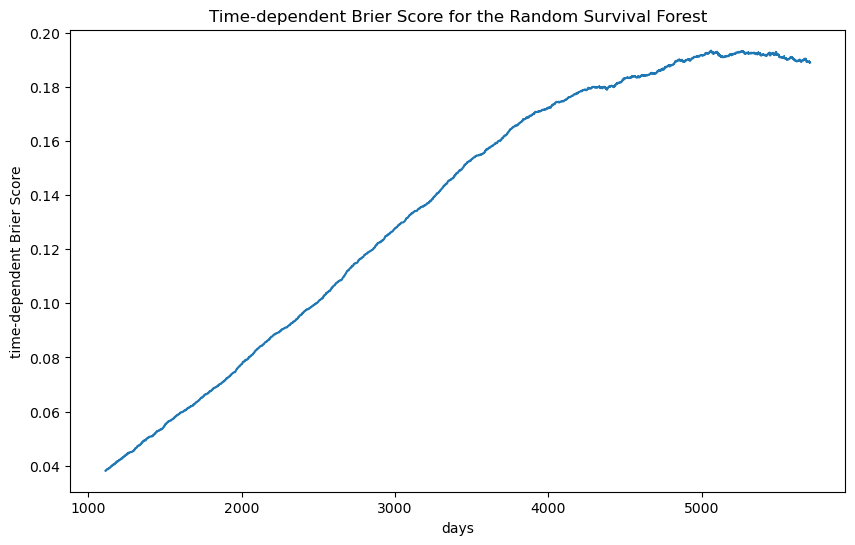

In [22]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))
plt.plot(bs[0], bs[1], marker=",")
# plt.axhline(ibs, linestyle="--")
# plt.text(5, 0, "{model}", fontsize=12)
plt.title("Time-dependent Brier Score for the Random Survival Forest")
plt.xlabel("days")
plt.ylabel("time-dependent Brier Score")

In [25]:
import pickle

with open('pickle/brier/BS_COXNET_LIVING_FINAL.pickle', 'wb') as f:
    pickle.dump(bs, f)


In [27]:
lower, upper = np.percentile(y_train["Days"], [10, 90])
times = np.arange(lower, upper + 1)
cph_risk_scores = coxnet_pred.predict(X_test)
auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)

with open('pickle/AUC/AUC_COXNET_LIVING_FINAL.pickle', 'wb') as f:
    pickle.dump((times, auc, mean_auc), f)

In [ ]:
import matplotlib.pyplot as plt

number = 9

# Plot the step function
# plt.step(res[number].x, res[number].y)

# fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Flatten the axs array to make it easier to iterate over
# axs = axs.flatten()

# for i, (ax, sf) in enumerate(zip(axs, res[:number])):
#     ax.step(sf.x, sf.y)

# plt.show()


# Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

# uncoment if you want to calculate permutation importance (data must not be processed by pipeline)
# result = permutation_importance(coxnet_pred, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)

In [ ]:
pd.set_option('display.max_rows', None)

# columns = numeric_features + categorical_features

importances_df = pd.DataFrame(result.importances_mean, index=X_test.columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
print(importances_df)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'